<a href="https://colab.research.google.com/github/MuneerHussain01/Dental-Query-Chatbot/blob/main/Dental_Query_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/514 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss



Classification Report:
                                                                                                             precision    recall  f1-score   support

          A dental abscess is a pus-filled infection in the tooth or gums, often causing pain and swelling.       0.00      0.00      0.00         1
                                 A dental avulsion is when a tooth is completely knocked out of its socket.       0.67      1.00      0.80         2
           A dental bridge is a fixed appliance that replaces missing teeth by anchoring to adjacent teeth.       0.00      0.00      0.00         2
                   A dental cyst is a fluid-filled sac near a tooth root, often requiring surgical removal.       0.00      0.00      0.00         1
                              A dental diastema is a gap or space between two teeth, often the front teeth.       1.00      1.00      1.00         3
                       A dental filling is a material used to restore a tooth dam

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-1-0429b2c6d1a8>:86: UserWarning: T

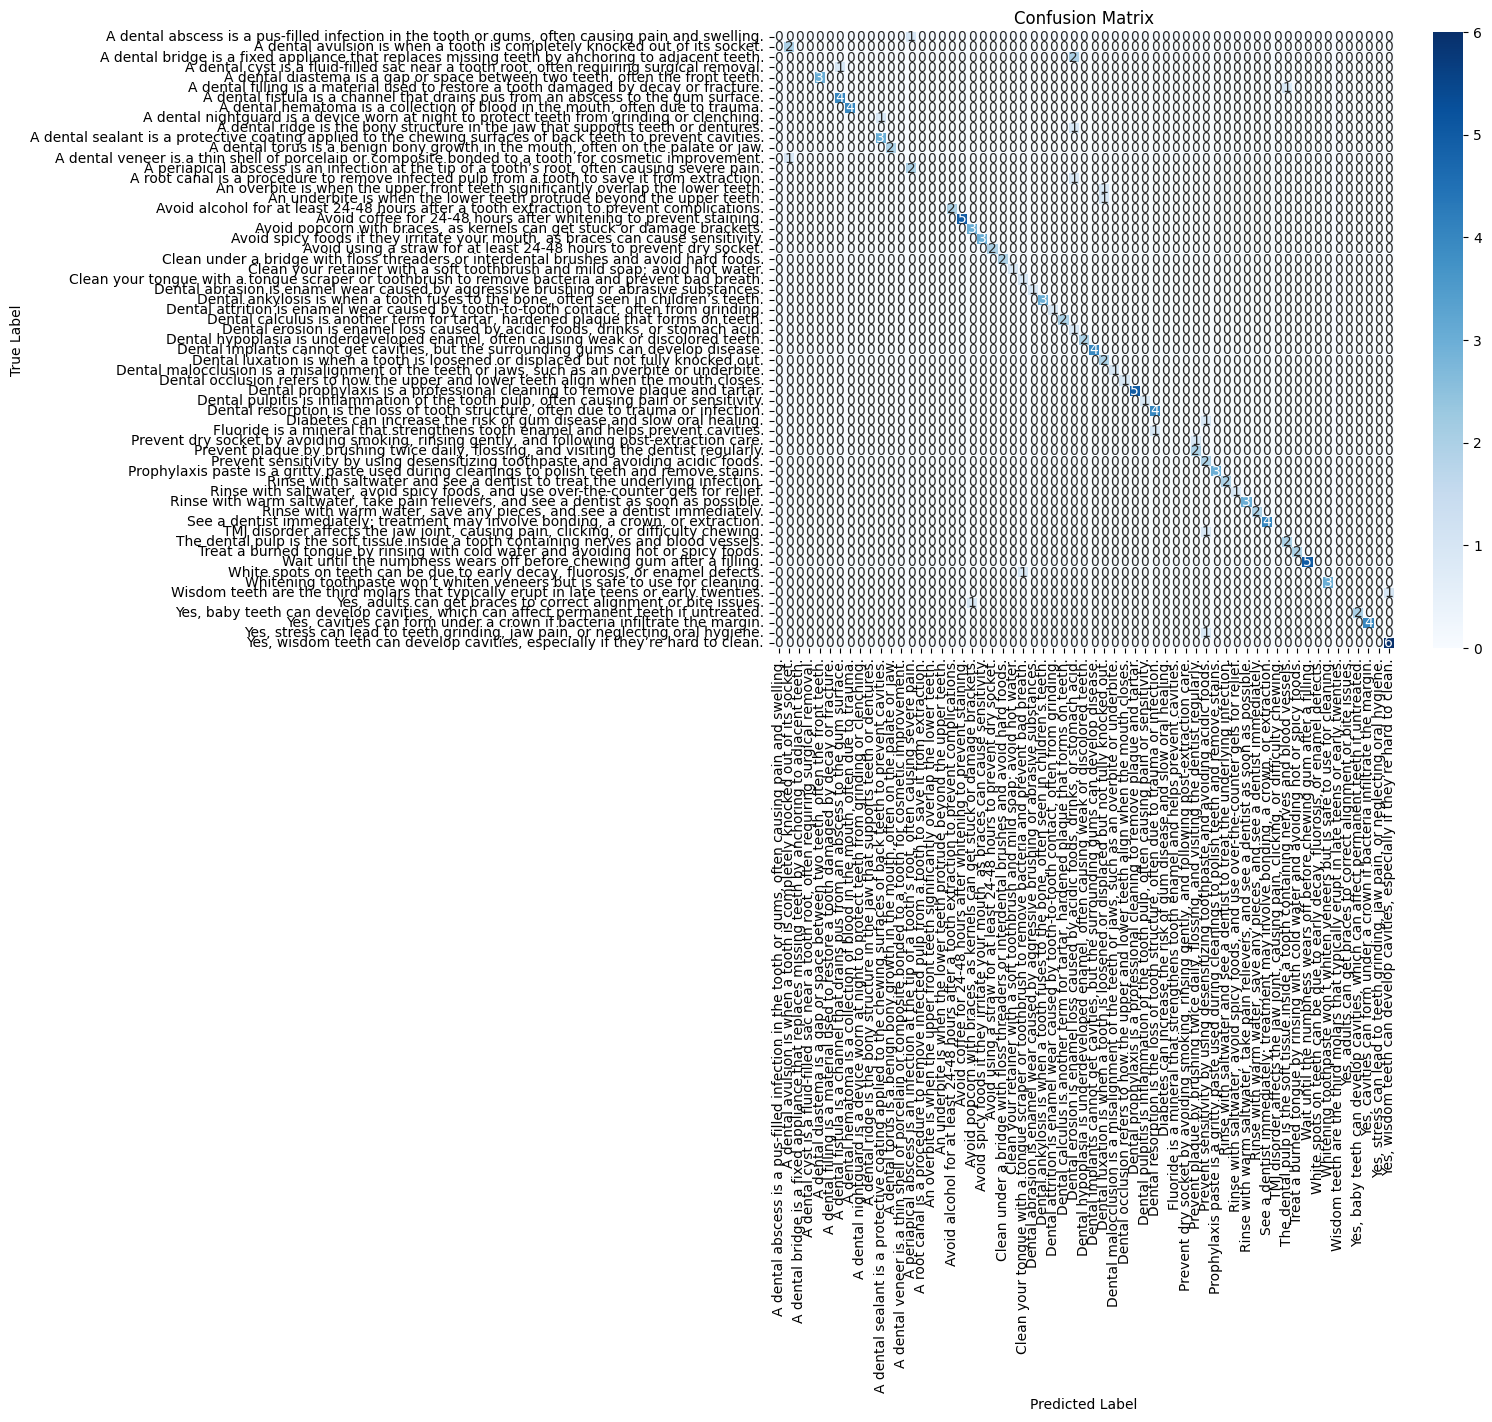

In [1]:
!pip install -U transformers datasets scikit-learn seaborn

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

# Disable Weights & Biases logging (optional)
import os
os.environ["WANDB_DISABLED"] = "true"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dental_health_dataset.csv')
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Tokenization
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# Prepare dataset
dataset = Dataset.from_pandas(df[['text', 'label_encoded']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)
tokenized_ds = dataset.map(tokenize, batched=True)
tokenized_ds = tokenized_ds.rename_column("label_encoded", "labels")
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    logging_dir='./logs'
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"]
)

# Train
trainer.train()

# Predictions
predictions = trainer.predict(tokenized_ds["test"])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# ✅ Fix: Use only labels/classes present in test set
used_labels = unique_labels(y_true, y_pred)
used_class_names = label_encoder.inverse_transform(used_labels)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=used_labels, target_names=used_class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=used_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=used_class_names, yticklabels=used_class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [2]:
pip install gradio joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.0 MB/s eta 0:00:00


In [3]:
import joblib
joblib.dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

In [4]:
trainer.save_model("./results")

In [5]:
import gradio as gr
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import joblib

# Load trained model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("./results")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load label encoder (you should save this during training)
label_encoder = joblib.load("label_encoder.joblib")

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs, dim=1).item()
    label = label_encoder.inverse_transform([pred])[0]
    confidence = probs[0][pred].item()
    return {label: float(round(confidence, 3))}

interface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=2, placeholder="Enter a dental query..."),
    outputs=gr.Label(num_top_classes=3),
    title="Dental Query Chatbot",
    description="Enter a dental-related question and the model will classify it."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://90e0cc92522dad10ee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [14]:
!nbstripout "/content/drive/My Drive/Colab Notebooks/Dental_Query_Chatbot.ipynb"
